Author: Tashay Green

An interesting urban question is "can we measure and predict energy use based on observables that are easier to be acquired". For example the urban observatory at CUSP can monitor lights: they are a realtively easy observable. All you need is a camera, and a pipeline to process your data. But how does the light coming from a window relate to the total energy consumption? We generally postulate that light is a proxy for occupancy, and that occupancy is a good predictor of energy consumption.

So let's test if the last link holds. If we have data on the energy consumed by a building how well does that relate to the number of units in the building?

In [1]:
import geopandas as gp
import pandas as pd
import pylab as pl
import os
import json
import zipfile
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy.polynomial.polynomial as poly
from numpy.polynomial import Polynomial
from pandas.tools.plotting import scatter_matrix

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['poly']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Read in Data for Exploration

In [2]:
os.getenv('PUIDATA')
dataFile = os.getenv('PUIDATA') + '/' + 'Energy_and_Water_Data_Disclosure_for_Local_Law_84__2013_.csv'
nrg = pd.read_csv(dataFile)

In [3]:
myzip = zipfile.ZipFile(os.getenv('PUIDATA') + '/' + 'mn_mappluto_16v1.zip')
myzip.extractall()
myzip.open('MNMapPLUTO.shp')
bsize = gp.read_file('MNMapPLUTO.shp')

## Select Relevant Data

In [4]:
nrg.columns
nrg.rename(columns={'NYC Borough, Block, and Lot (BBL)':'BBL'}, inplace=True)
nrg = nrg [['BBL','Zip Code','Reported Property Floor Area (Building(s)) (ft²)', 'DOF Number of Buildings', 'Site EUI(kBtu/ft2)']]
nrg.head()

,BBL,Zip Code,Reported Property Floor Area (Building(s)) (ft²),DOF Number of Buildings,Site EUI(kBtu/ft2)
0,1.000410e+09,NaN,918919,NaN,NaN
1,4.021460e+09,11375.0,NaN,1.0,NaN
2,2.027620e+09,NaN,64200,NaN,NaN
3,1.006700e+09,10001.0,NaN,1.0,NaN
4,2.048300e+09,NaN,50000,NaN,NaN


In [5]:
bsize.columns
bsize = bsize[['BBL','UnitsRes','UnitsTotal','ZipCode']]
bsize.head()

,BBL,UnitsRes,UnitsTotal,ZipCode
0,1.015450e+09,16,18,10028
1,1.007238e+09,50,50,10001
2,1.016800e+09,10,10,10029
3,1.013850e+09,29,32,10021
4,1.011970e+09,26,26,10024


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbae83a9438>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fbad76055f8>]], dtype=object)

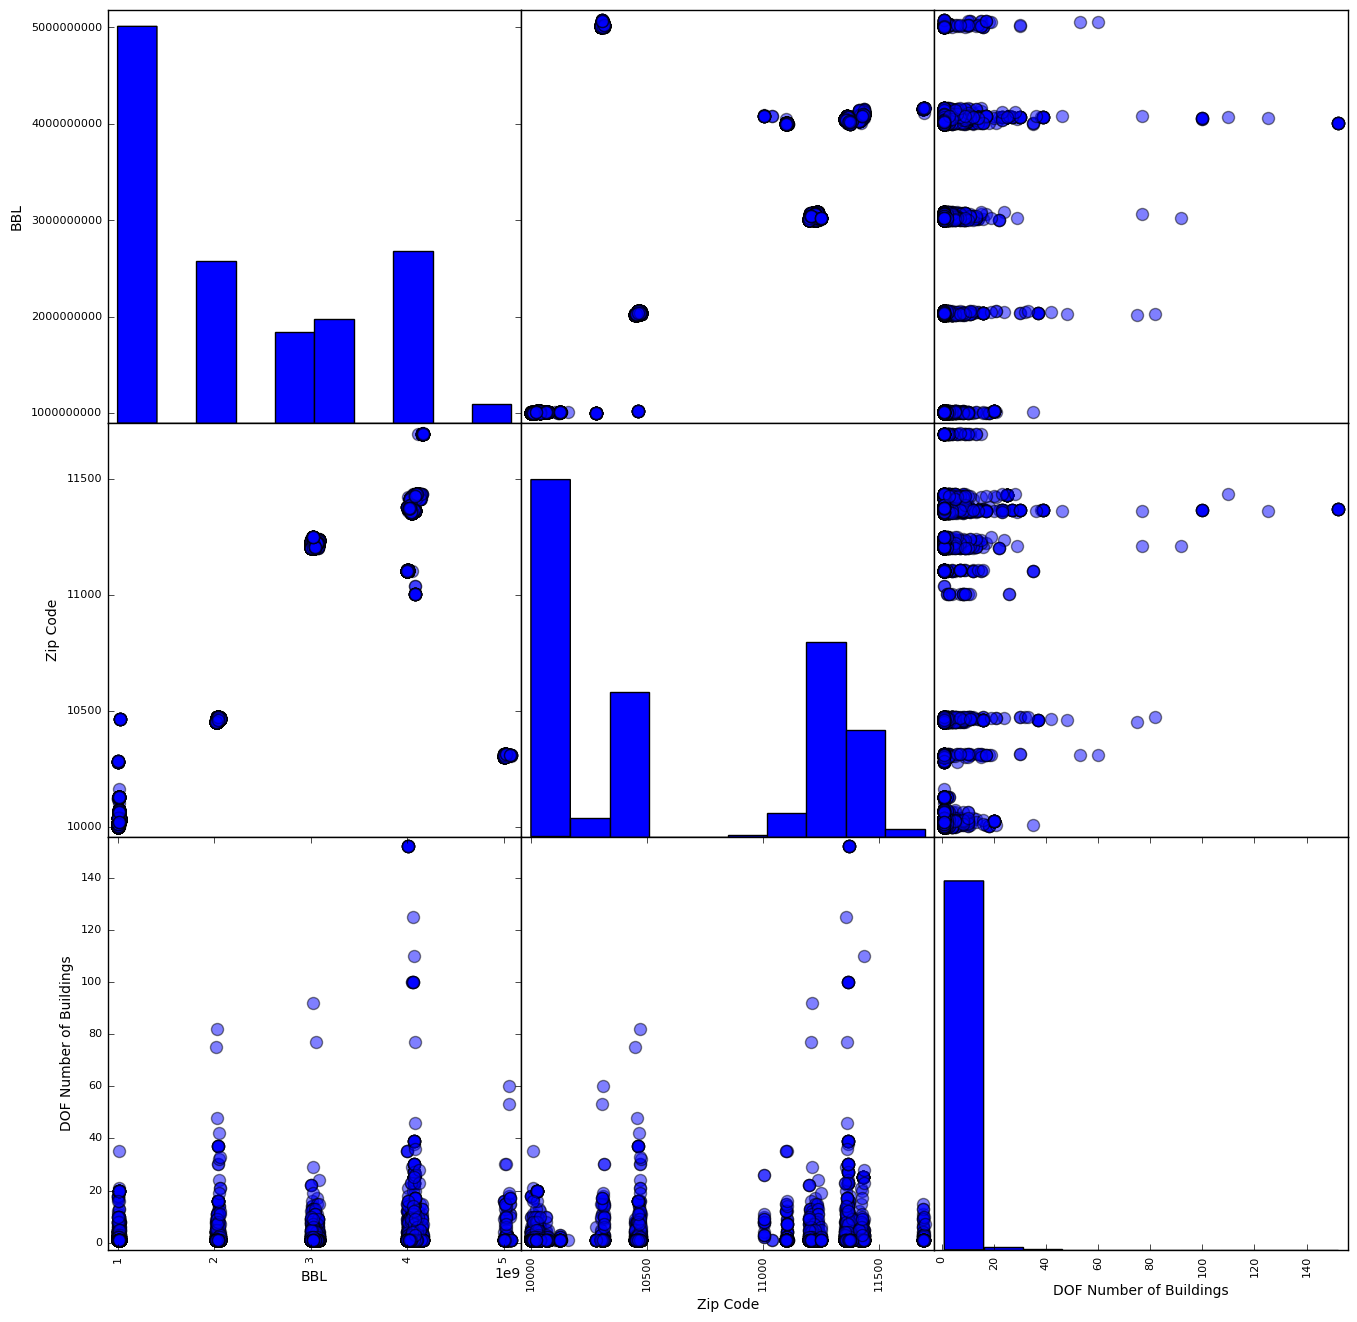

In [6]:
# Scatter matrix of nrg data.
scatter_matrix (nrg, s=300, figsize=(16, 16))

Figure 1: Scatter matrix of all numerical values in segmented NRG dataframe. 

In [7]:
# Return the types of each value in nrg data frame.
nrg.dtypes

BBL                                                 float64
Zip Code                                            float64
Reported Property Floor Area (Building(s)) (ft²)     object
DOF Number of Buildings                             float64
Site EUI(kBtu/ft2)                                   object
dtype: object

In [8]:
# Convert objects to numerical values in preparation for merging.
nrg['Site EUI(kBtu/ft2)'] = pd.to_numeric(nrg['Site EUI(kBtu/ft2)'],errors = 'coerce')
nrg['Reported Property Floor Area (Building(s)) (ft²)'] = pd.to_numeric(nrg['Reported Property Floor Area (Building(s)) (ft²)'],errors = 'coerce')

In [9]:
# Return the types of each value in bsize data frame.
bsize.dtypes

BBL           float64
UnitsRes        int64
UnitsTotal      int64
ZipCode         int64
dtype: object

## Merge Data Frames

In [10]:
# Merge data frames on unique value BBL.
bblData = pd.merge(nrg, bsize, on = 'BBL')
bblData.head()

,BBL,Zip Code,Reported Property Floor Area (Building(s)) (ft²),DOF Number of Buildings,Site EUI(kBtu/ft2),UnitsRes,UnitsTotal,ZipCode
0,1.006700e+09,10001.0,NaN,1.0,NaN,0,1,10001
1,1.004370e+09,10009.0,NaN,1.0,NaN,0,4,10009
2,1.013110e+09,10022.0,330000.0,1.0,125.4,0,56,10022
3,1.009220e+09,10003.0,NaN,1.0,NaN,148,148,10003
4,1.007400e+09,NaN,68329.0,NaN,NaN,0,1,10011


In [11]:
bblData['TotalEnergyUsed'] = bblData['Site EUI(kBtu/ft2)'] * bblData['Reported Property Floor Area (Building(s)) (ft²)']

In [12]:
bblData.describe()

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/function_base.py:3403: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


,BBL,Zip Code,Reported Property Floor Area (Building(s)) (ft²),DOF Number of Buildings,Site EUI(kBtu/ft2),UnitsRes,UnitsTotal,ZipCode,TotalEnergyUsed
count,6.492000e+03,5964.000000,5.579000e+03,5974.000000,5.077000e+03,6492.000000,6492.000000,6492.000000,5.069000e+03
mean,1.012037e+09,10028.693662,2.139771e+05,1.275527,1.161758e+03,96.906038,108.948090,10028.479821,2.136455e+08
std,5.665916e+06,37.701012,3.248771e+05,1.697660,4.272501e+04,248.653949,252.170956,37.193135,5.245490e+09
min,1.000010e+09,10001.000000,0.000000e+00,1.000000,0.000000e+00,0.000000,0.000000,10001.000000,0.000000e+00
25%,1.008180e+09,NaN,NaN,NaN,NaN,0.000000,17.000000,10013.000000,NaN
50%,1.012344e+09,NaN,NaN,NaN,NaN,49.000000,58.000000,10022.000000,NaN
75%,1.015438e+09,NaN,NaN,NaN,NaN,106.250000,116.000000,10031.000000,NaN
max,1.022500e+09,10463.000000,9.515627e+06,35.000000,3.018493e+06,8759.000000,8805.000000,10463.000000,3.501452e+11


## Plotting the Data

(1, 1000)

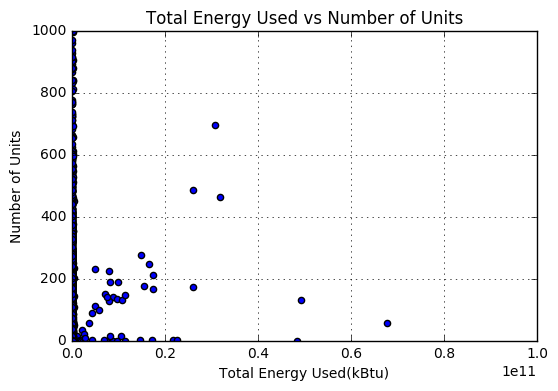

In [13]:
# Zoomed out view of Total Energy Used vs Number of Units. 
pl.scatter(bblData['TotalEnergyUsed'], bblData['UnitsTotal'])
pl.xlabel('Total Energy Used(kBtu)')
pl.ylabel('Number of Units')
pl.title('Total Energy Used vs Number of Units')
pl.grid(True)
xlim(1000,1e11)
ylim(1,1000)

Figure 2: Zoomed out view of Total Energy Used vs Number of Units in a building. 

(1, 1000)

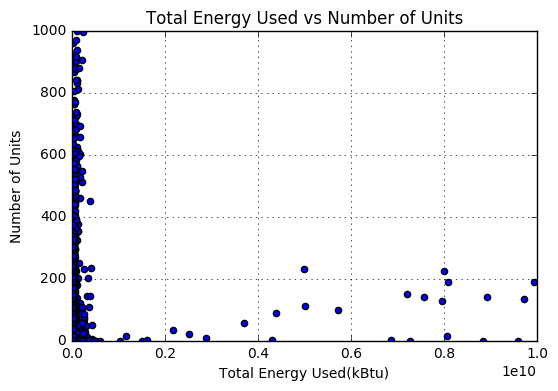

In [14]:
# Zoomed in view of Total Energy Used vs Number of Units.
pl.scatter(bblData['TotalEnergyUsed'], bblData['UnitsTotal'])
pl.xlabel('Total Energy Used(kBtu)')
pl.ylabel('Number of Units')
pl.title('Total Energy Used vs Number of Units')
pl.grid(True)
xlim(1000,1e10)
ylim(1,1000)

Figure 3: Zoomed in view of Total Energy Used vs the Number of Units in a building. 

In [15]:
# Remove outliers that are zero.
bblData.drop(bblData[bblData['TotalEnergyUsed'] < 1].index, axis = 0, inplace = True)
bblData.drop(bblData[bblData['UnitsTotal'] < 1].index, axis = 0, inplace = True)
bblData.head()

,BBL,Zip Code,Reported Property Floor Area (Building(s)) (ft²),DOF Number of Buildings,Site EUI(kBtu/ft2),UnitsRes,UnitsTotal,ZipCode,TotalEnergyUsed
0,1.006700e+09,10001.0,NaN,1.0,NaN,0,1,10001,NaN
1,1.004370e+09,10009.0,NaN,1.0,NaN,0,4,10009,NaN
2,1.013110e+09,10022.0,330000.0,1.0,125.4,0,56,10022,41382000.0
3,1.009220e+09,10003.0,NaN,1.0,NaN,148,148,10003,NaN
4,1.007400e+09,NaN,68329.0,NaN,NaN,0,1,10011,NaN


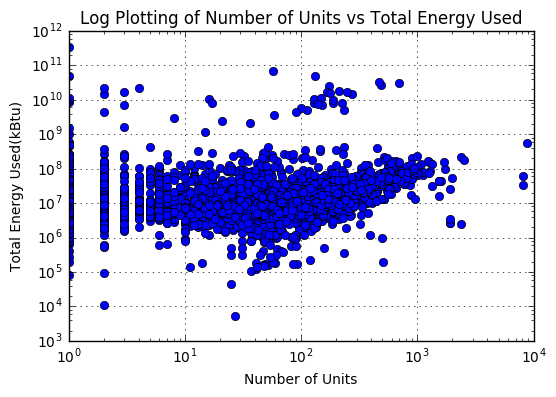

In [16]:
# log plot of Total Energy Used vs Number of Units.
pl.loglog(bblData['UnitsTotal'], bblData['TotalEnergyUsed'], 'o')
pl.xlabel('Number of Units')
pl.ylabel('Total Energy Used(kBtu)')
pl.title('Log Plotting of Number of Units vs Total Energy Used')
pl.grid(True)

Figure 4: Log plot of Number of Units in a building vs Total Energy Used. 

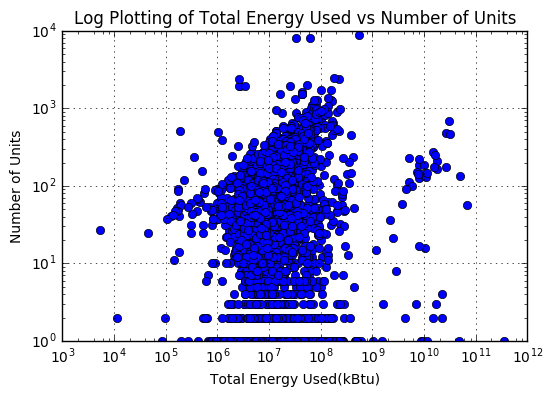

In [17]:
pl.loglog(bblData['TotalEnergyUsed'],bblData['UnitsTotal'], 'o')
pl.xlabel('Total Energy Used(kBtu)')
pl.ylabel('Number of Units')
pl.title('Log Plotting of Total Energy Used vs Number of Units')
pl.grid(True)

Figure 5: Log plot of Total Energy Used vs Number of Units in a building. 

## Fitting the Data 

### 1. Units vs. Energy

In [18]:
# Fit data to OLS model.
bblData = bblData.dropna(axis = 0, how = 'any', subset = ['TotalEnergyUsed'])
bblData['LogTotalEnergyUsed'] = np.log10(bblData['TotalEnergyUsed'])
bblData['LogUnitsTotal'] = np.log10(bblData['UnitsTotal'])
bblData.drop(bblData[bblData['LogUnitsTotal'] < 1].index, axis = 0, inplace = True)

model = smf.ols('LogTotalEnergyUsed ~ LogUnitsTotal', data = bblData).fit()

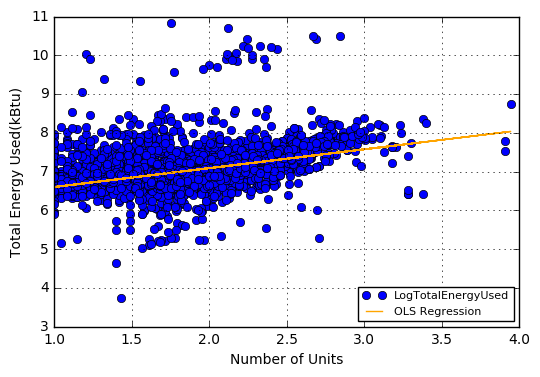

In [19]:
# Plot OLS regression and log plot. 
pl.plot(bblData['LogUnitsTotal'], bblData['LogTotalEnergyUsed'], 'o')
pl.xlabel('Number of Units')
pl.ylabel('Total Energy Used(kBtu)')
pl.grid(True)

pl.plot(bblData['LogUnitsTotal'], model.predict(), color = 'orange', label = 'OLS Regression')
pl.legend(loc = 'lower right', fontsize = 8)

Figure 6: Log plot of Number of Units in a building vs Total Energy Used, fitted with an OLS Regression. 

### 2. Units vs. Energy

In [20]:
# Fit data to OLS model.
model2 = smf.ols('LogUnitsTotal ~ LogTotalEnergyUsed', data = bblData).fit()

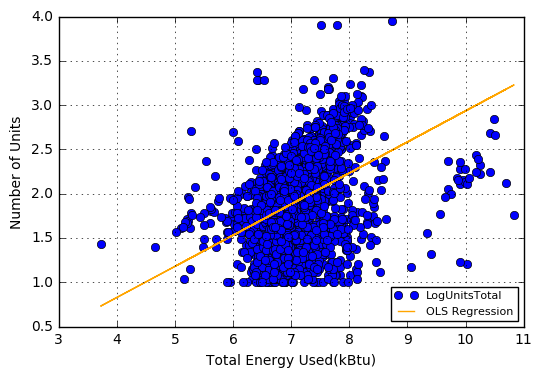

In [21]:
# Plot OLS regression and log plot. 
pl.plot(bblData['LogTotalEnergyUsed'],bblData['LogUnitsTotal'], 'o')
pl.xlabel('Total Energy Used(kBtu)')
pl.ylabel('Number of Units')
pl.grid(True)

pl.plot(bblData['LogTotalEnergyUsed'], model2.predict(), color = 'orange', label = 'OLS Regression')
pl.legend(loc = 'lower right', fontsize = 8)

Figure 7: Log plot of Total Energy Used vs Number of Units in a building, fitted with an OLS Regression. 

### 3. Evaluate Which Model is Better By Calculating the Chi-Square

In [22]:
chisq = np.sum((((model.predict() - bblData['LogTotalEnergyUsed'])**2)/(bblData['LogTotalEnergyUsed'])))
print (chisq)

111.767606358


In [23]:
chisq2 = np.sum((((model2.predict() - bblData['LogUnitsTotal'])**2)/(bblData['LogUnitsTotal'])))
print (chisq2)

371.397898482


### 4. Fit Units vs Energy with 2nd Degree Polynomial

In [27]:
bblData = bblData.sort_values('LogUnitsTotal')
#coefs = np.polyfit(bblData['LogUnitsTotal'], bblData['LogTotalEnergyUsed'], 2)
#ffit = Polynomial(coefs)
#pl.plot(bblData['LogUnitsTotal'], ffit(bblData['LogUnitsTotal']))

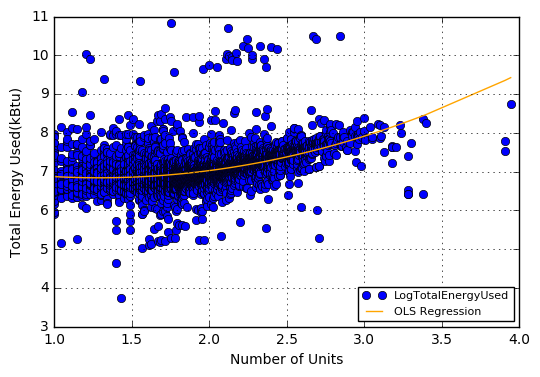

In [28]:
# Add column for LogUnitsTotalSquared values
bblData['LogUnitsTotalSquared'] = bblData['LogUnitsTotal']**2

# Fit model
model3 = smf.ols('LogTotalEnergyUsed ~ LogUnitsTotalSquared + LogUnitsTotal', data = bblData).fit()


# Plot second degree polynomial
pl.plot(bblData['LogUnitsTotal'], bblData['LogTotalEnergyUsed'], 'o')
pl.xlabel('Number of Units')
pl.ylabel('Total Energy Used(kBtu)')
pl.grid(True)

pl.plot(bblData['LogUnitsTotal'], model3.predict(), color = 'orange', label = '2nd Degree Polynomial')
pl.legend(loc = 'lower right', fontsize = 8)

Figure 8: Log plot of Number of Units in a building vs Total Energy Used, fitted with a 2nd degree polynomial. 

### 5. Likelihood Ratio Test

**Idea**: The 2nd Degree polynomial fit will more accurately describe the data. 

**H<sub>o</sub>**: The 2nd degree polynomial will equally or less accurately describe the Unit vs Energy data, than the OLS Regression. Significance level = 0.05

**H<sub>a</sub>**: The 2nd degree polynomial will more accurately describe the Unit vs Energy data, than the OLS regression. Significance level = 0.05

In [29]:
print ("LR : ", -2 * (-model3.llf - (-model.llf)))
print ("LR from statsmodels:", model3.compare_lr_test(model))

LR :  201.323651815
LR from statsmodels: (201.32365181516434, 1.0739550136377564e-45, 1.0)


Since the p-value is less than .05 we can **reject** the Null Hypothesis and accept the Alternate Hypothesis. 